# MFI: Measure of Feature Importance
*Vidovic, Marina M-C., et al. "Feature Importance Measure for Non-linear Learning Algorithms." arXiv preprint arXiv:1611.07567 (2016).*

--> Runner-up best paper award NIPS 2016 workshop: Interpretable ML for Complex Systems

MFI is an explanation technique that can be applied to any predictive model that handles binary classification or regression. It has two explanation modes:
* **Instance-based:** For a new given instance, explain why it has been given a high or low score by our model. *Useful in critical domains: law enforcement, financial domain, health care, ...*

* **Model-based:** Provide insight of the model. *Useful to 'debug'/improve your model*

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tools
import numpy as np
import pickle
import os
import view
import copy

from sklearn.svm import SVC
from sklearn.metrics.pairwise import pairwise_kernels

import matplotlib
import matplotlib.pyplot as plt

## Read the data (MNIST digits: classes 3 and 8)

In [3]:
# CREATE RESULT FOLDER
if not os.path.exists("results"):
    os.makedirs("results")


# READ DATA
print("LOAD/READ DATA")
xtrain,ytrain,xtest,ytest = tools.read_data()
numbers = [4,9]  # Somehow, these numbers correspond to the classes 3 and 8
x,y = tools.choose_numbers(xtrain,ytrain,numbers)
xt,yt = tools.choose_numbers(xtest,ytest,numbers)
print("LOAD/READ DATA --- DONE!")

LOAD/READ DATA
LOAD/READ DATA --- DONE!


## Generate random samples

In [4]:
np.random.seed(1337)

# 3 Digits
class3_digits = xt[yt == 4]
class3_samples = class3_digits[np.random.choice(len(class3_digits), 6, replace=False)]

# 8 Digits
class8_digits = xt[yt == 9]
class8_samples = class8_digits[np.random.choice(len(class8_digits), 6, replace=False)]

# Noise
samplesize = 5000
noise = np.random.uniform(-1.,1.,(samplesize,len(x[0])))  #np.random.uniform(0.,1.,(samplesize,len(x[0])))
noise_samples = noise[np.random.choice(samplesize, 6, replace=False)]

## Some examples

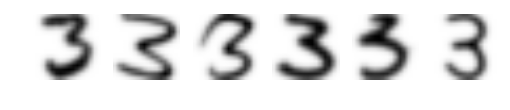

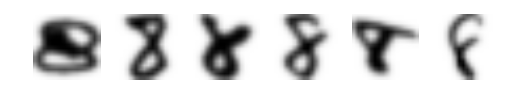

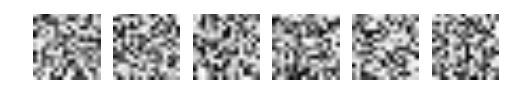

In [5]:
def plot_figures(samples, cmap_string='Greys'):
    fig = plt.figure()
    for i, digit in enumerate(samples):
        ax = fig.add_subplot(1, len(samples), i+1)
        ax.imshow(np.reshape(digit, (16, 16)), cmap=plt.cm.get_cmap(cmap_string))
        ax.axis('off')
    plt.show()
    
plot_figures(class3_samples)
plot_figures(class8_samples)
plot_figures(noise_samples)

# Instance-based explanation for SVM

* Generate N noise samples
* For each sample, and for each feature, replace one feature by the feature value of the instance
* Measure the mean classifier output
* If the classifier output is high ==> important for class 1; else important for class 0

In [6]:
def mfi_ib(svm, x_rnd, x):
    mfi = np.zeros((len(x_rnd[0])))
    for i in range(len(x_rnd[0])):
        xi = copy.deepcopy(x_rnd)
        xi[:,i] = x[i]
        sx = svm.decision_function(xi)
        mfi[i] = np.mean(sx)
    return mfi

In [7]:
clf = SVC(kernel='rbf')
clf.fit(x, y)
print('Class 3 predictions:', [clf.predict(np.reshape(sample, (1, -1))) for sample in class3_samples])
print('Class 8 predictions:', [clf.predict(np.reshape(sample, (1, -1))) for sample in class8_samples])

('Class 3 predictions:', [array([ 4.]), array([ 4.]), array([ 4.]), array([ 4.]), array([ 4.]), array([ 4.])])
('Class 8 predictions:', [array([ 9.]), array([ 4.]), array([ 9.]), array([ 9.]), array([ 9.]), array([ 9.])])


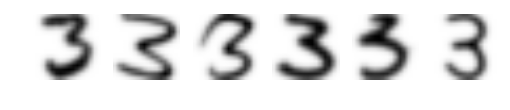

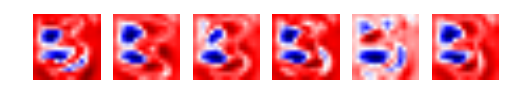

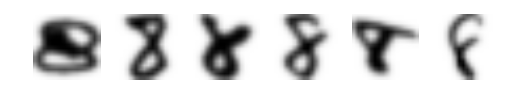

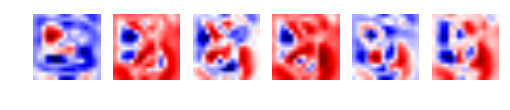

In [8]:
plot_figures(class3_samples)
plot_figures([mfi_ib(clf, noise, sample) for sample in class3_samples], cmap_string='seismic')

plot_figures(class8_samples)
plot_figures([mfi_ib(clf, noise, sample) for sample in class8_samples], cmap_string='seismic')

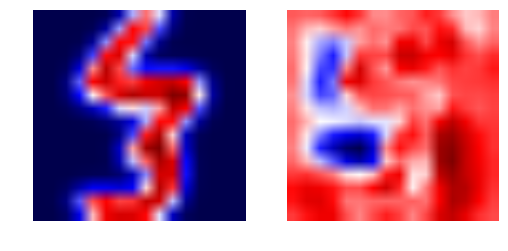

In [9]:
for digit in class3_digits:
    if clf.predict(np.reshape(digit, (1, -1))) != 4:
        wrong_prediction = digit
        break
plot_figures([wrong_prediction, mfi_ib(clf, noise, wrong_prediction)], cmap_string='seismic')

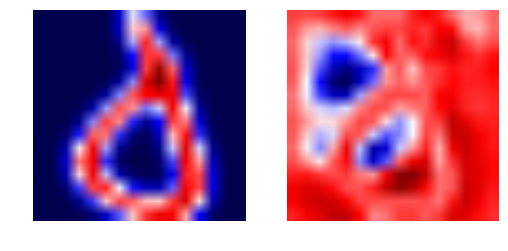

In [10]:
for digit in class8_digits:
    if clf.predict(np.reshape(digit, (1, -1))) != 9:
        wrong_prediction = digit
        break
plot_figures([wrong_prediction, mfi_ib(clf, noise, wrong_prediction)], cmap_string='seismic')

# Model-based explanation for SVM

* Create prediction for every noise sample
* Calculate pairwise kernel matrix (#samples x #samples)
* Now we take one certain feature (aka pixel) of these noise samples and calculate a new pairwise kernel matrix
* Now we calculate the dependency between those two matrices. If they are highly dependent, then the feature must be important! Dependency calculation is done by using Hilbert=Schmidt Independence Criterion

In [11]:
def mfi_mb(predictions, x_rnd, metric, degree=2):
    # KERNEL MATRIX FOR S(X)
    if metric == "poly":
        km_s = pairwise_kernels(predictions, Y=None, metric=metric, degree=degree)
    else:
        km_s = pairwise_kernels(np.reshape(predictions, (len(predictions), 1)), Y=None, metric=metric)
    # NORMALIZE
    row_sums = km_s.sum(axis=1)
    km_s = km_s / row_sums[:, np.newaxis]
    # KERNEL MATRIX FOR X_ij OF ALL SAMPLES
    mfi = np.zeros(len(x_rnd[0]))
    for i in range(len(x_rnd[0])):
        if metric == "poly":
            km_x = pairwise_kernels(np.reshape(x_rnd[:, i], (len(x_rnd), 1)), Y=None, metric=metric, degree=degree)
        else:
            km_x = pairwise_kernels(np.reshape(x_rnd[:, i], (len(x_rnd), 1)), Y=None, metric=metric)
        if metric != "linear" and metric != "cosine":
            row_sums = km_x.sum(axis=1)
        km_x = (km_x) / row_sums[:, np.newaxis]
        A = np.dot(km_s, km_x)
        mfi[i] = np.trace(A)

    return mfi

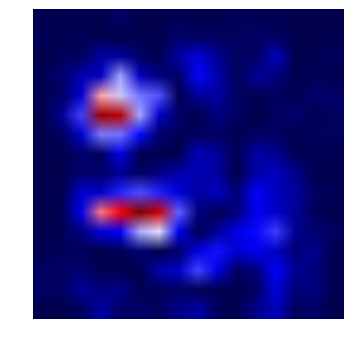

In [12]:
mbr = mfi_mb(clf.decision_function(noise), noise, 'rbf', degree=2)
plot_figures([mbr], cmap_string='seismic')